In [25]:
import csv
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt 

##Planteamiento del Problema de Flujo en Redes, para un Sistema Eléctrico



El problema que queremos resolver consiste en suministrar el total
de la demanda de electricidad de un sistema eléctrico ficticio de 10 nodos, de los cuales se tiene 1 nodo que es solo de generación, 3 de generación y carga y 6 que son solo de carga (ver Figura 1).

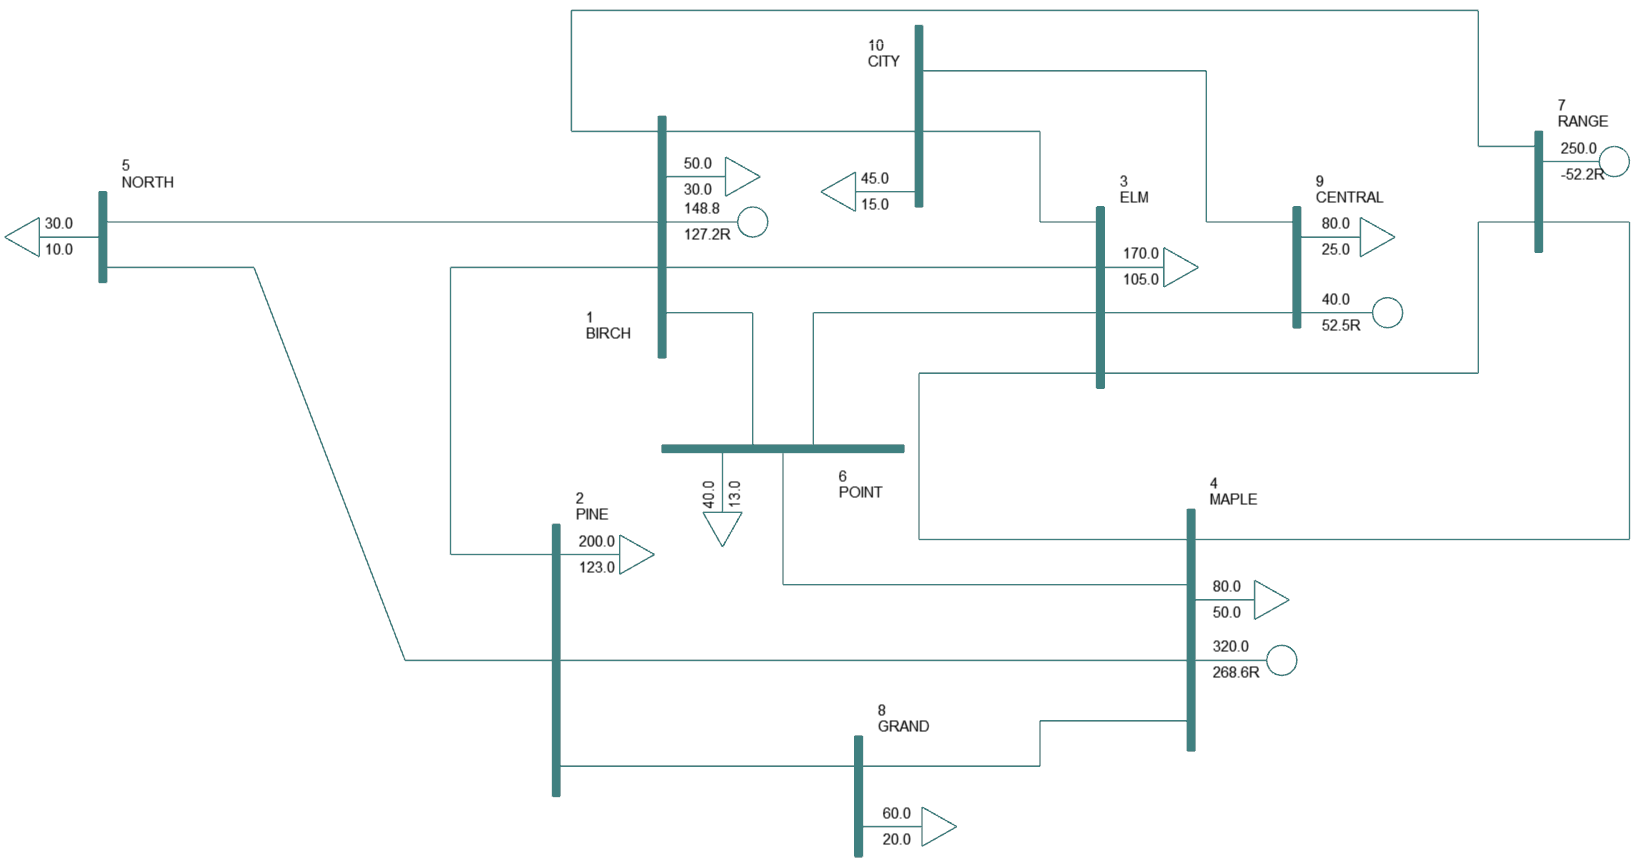


En la práctica, este diagrama tiene las siguientes representaciones:
-	Cada nodo es una subestación eléctrica
-	Las ramas son lineas de transmisión
-	Los nodos con el símbolo de generador (círculo) son centrales eléctricas de generación
-	Los nodos con el símbolo de carga (triangulo) son las cargas del sistema, que representan algún equipo, o industria, o la suma de ambas (también pueden representar el consumo de energía de una ciudad o localidad).

Lo que intentaremos resolver, con un modelo de Programación Lineal, es la solución que minimiza las pérdidas en la transferencia de energía eléctrica a través de las líneas de transmisión, de modo que el flujo neto satisfaga lo representado en la red, considerando el flujo neto como el flujo total que sale del nodo menos el flujo total qe entra en el nodo.

La función de costos que se plantea considera las ecuaciones de conservación de flujo y los costos asociados a la transmisión de energía por cada rama se consideran en función de uno de sus parámetros eléctricos: su resistencia. Por lo tanto, el valor que pretendemos minimizar son las pérdidas de energía, ya que los elementos con mayor resistencia representan mayor pérdida de energía por el efecto [Joule](https://es.wikipedia.org/wiki/Efecto_Joule). 





La solución que nos da este problema utilizando un software especializado para resolver el problema de [Flujos de Potencia](https://www.intechopen.com/chapters/65445) nos da el siguiente resultado, del cual obtenemos las direcciones en las que se transmite el flujo de potencia en la red:

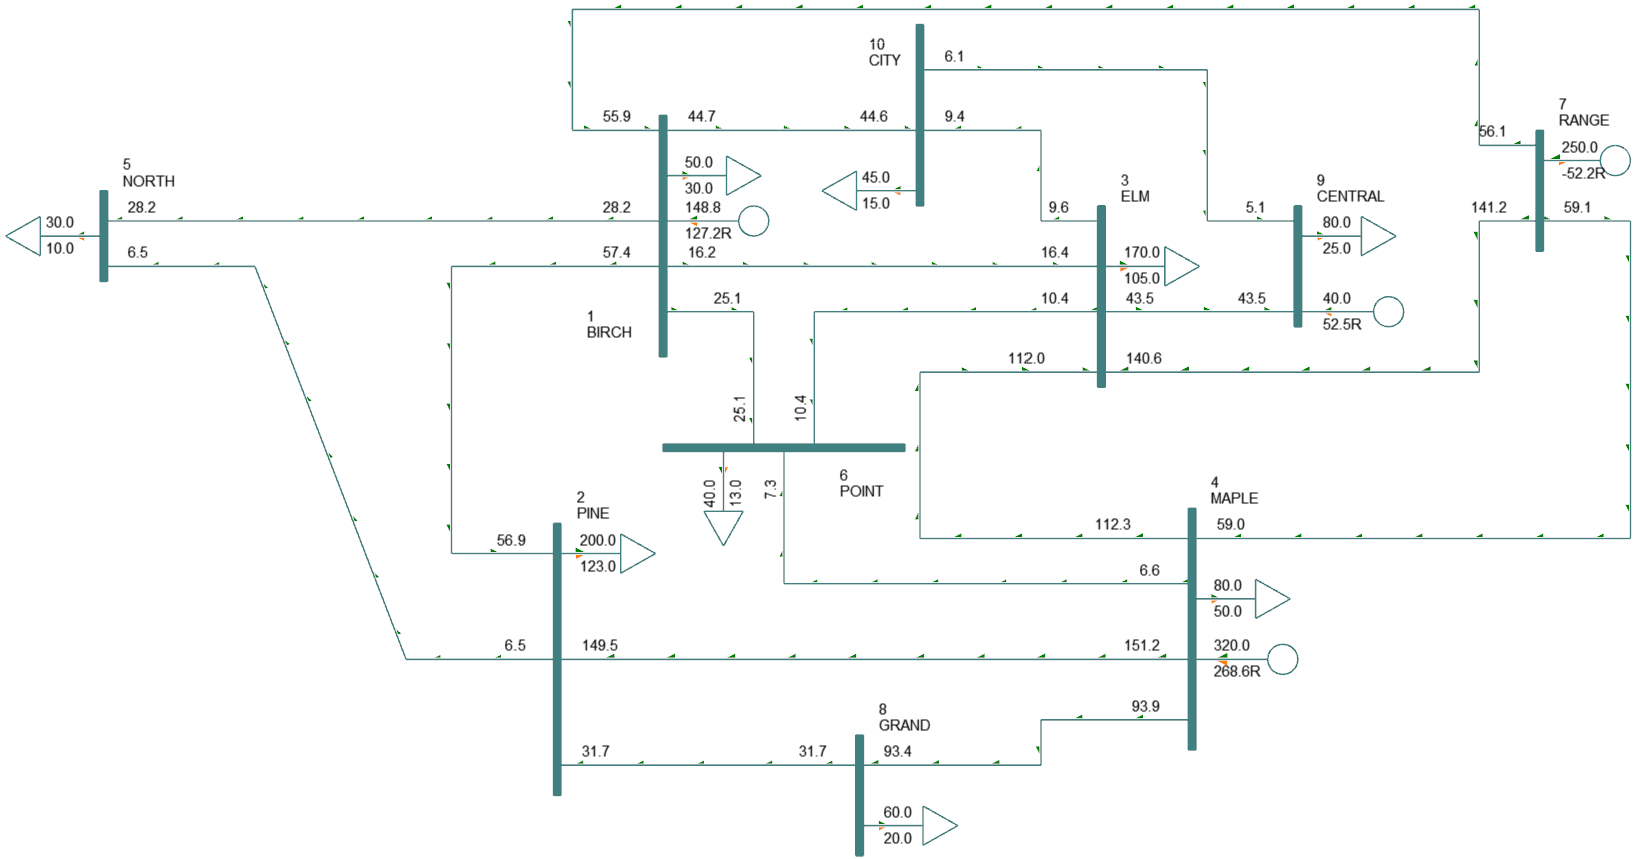

De esta manera el sistema de ecuaciones que se genera para representar esta red en el modelo de flujo en redes es con un sistema de ecuaciones como el siguiente:

$$
\begin{eqnarray}
&x_{1-2}& + &x_{1-3}& + &x_{1-5}& + &x_{1-6}&-&x_{1-7}& + &x_{1-10}& = 95 \nonumber \\
&-x_{1-2}& - &x_{2-4}& + &x_{2-5}& - &x_{2-8}& && && = -200 \nonumber \\
&-x_{1-3}& - &x_{3-4}& + &x_{3-6}& - &x_{3-7}& + &x_{3-9} + &x_{3-10} && = -170 \nonumber \\
&...\nonumber \\
&-x_{1-10}& - &x_{3-10}& + &x_{9-10}& && && &&  = -45 \nonumber \\
\nonumber
\end{eqnarray}
$$


La función de costos que habría que minimizar es la siguiente:

$$\displaystyle \min_{x \in \mathbb{R}^{18}} R_{1-2} x_{1-2} + R_{1-3} x_{1-3} + R_{1-5} x_{1-5} + R_{1-6} x_{1-6} + R_{1-7} x_{1-7} + ... + R_{9-10} x_{9-10}$$

Los arreglos que se generan a partir de estos sistema de ecuaciones son los siguientes:

**Matriz de Incidencias**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/repos/final_opt/incidencias10.csv')
incidencias = df.to_numpy()
incidencias = np.asmatrix(incidencias)

In [3]:
print(incidencias)

[[ 1  1  1  1 -1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0 -1  1 -1  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0 -1  1 -1  1  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0  0  0  1 -1  1  0]
 [ 0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  1]]


**Vector de Resistencias**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/repos/final_opt/reactancias10.csv')
costos = df["R"].to_numpy()

In [5]:
print(costos)

[0.00806  0.007039 0.016323 0.010664 0.015996 0.003061 0.003061 0.000102
 0.006121 0.00102  0.011651 0.005509 0.005885 0.005885 0.020739 0.012242
 0.001944 0.034491]


**Vector de flujo en neto en cada nodo**

In [6]:
df = pd.read_csv('/content/drive/MyDrive/repos/final_opt/balance10.csv')
b = df["Balance"].tolist()

In [7]:
print(b)

[95, -200, -170, 240, -30, -40, 250, -60, -40, -45]


**Se dan de alta los límites de cada rama.**

En este ejercicio se consideran límites abiertos en todos los elementos, es decir, no tienen límites de transmisión.

In [8]:
bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None),
          (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]

**Resolvemos el Programa Lineal planteado**

In [9]:
print(linprog(c = costos, A_eq = incidencias, b_eq = b, bounds = bounds))

     con: array([ 1.25270105e-09, -2.72484613e-09, -2.33922037e-09,  3.26144800e-09,
       -3.85302457e-10, -5.09160714e-10,  3.39846906e-09, -8.25657764e-10,
       -5.22945243e-10, -6.05488992e-10])
     fun: 3.290115003616031
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([5.00000000e+01, 6.74895814e-08, 5.96466458e-08, 1.72910740e-07,
       5.65626462e-08, 4.49999998e+01, 1.80000000e+02, 2.99999999e+01,
       8.33280515e-08, 5.05567220e-08, 3.99999998e+01, 2.50000000e+02,
       4.00000000e+01, 2.51705368e-07, 2.58258700e-08, 2.24151850e-08,
       6.00000001e+01, 1.39274260e-08])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [20]:
salida_pl = [5.00000000e+01, 6.74895814e-08, 5.96466458e-08, 1.72910740e-07,
       5.65626462e-08, 4.49999998e+01, 1.80000000e+02, 2.99999999e+01,
       8.33280515e-08, 5.05567220e-08, 3.99999998e+01, 2.50000000e+02,
       4.00000000e+01, 2.51705368e-07, 2.58258700e-08, 2.24151850e-08,
       6.00000001e+01, 1.39274260e-08]
salida_fp = [50.2,10.9,24.8,23.7,53,41.7,132,5.3,24.1,74,10.4,140,35.6,7.9,6,57,84.3,4.5]
ramas = ['R1-2','R1-3','R1-5','R1-6','R1-7','R1-10','R2-4','R2-5','R2-8','R3-4','R3-6',
         'R3-7','R3-9','R3-10','R4-6','R4-7','R4-8','R9-10']

## **Con cvxpy**

In [ ]:
import cvxpy as cp

In [ ]:
n = 18 #number of variables (branches)
x = cp.Variable(n, integer=False) #x as integer optimization variable
fo_cvxpy = costos.T@x #objective function
A_eq = incidencias

constraints = [A_eq@x == b,
               x >=0
               ]

In [ ]:
opt_objective = cp.Minimize(fo_cvxpy)

In [ ]:
prob = cp.Problem(opt_objective, constraints)
print(prob.solve())

3.2901150001093575


In [ ]:
# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)


The optimal value is 3.2901150001093575
A solution x is
[5.00000000e+01 1.56017138e-09 1.15929678e-09 1.31440379e-08
 1.54760473e-09 4.50000000e+01 1.80000000e+02 3.00000000e+01
 2.48323635e-09 1.87716788e-09 4.00000000e+01 2.50000000e+02
 4.00000000e+01 9.16198822e-09 7.41318084e-10 7.03674809e-09
 6.00000000e+01 4.23648111e-10]


In [23]:
salida_cvxpy = [5.00000000e+01, 1.56017138e-09, 1.15929678e-09, 1.31440379e-08,
 1.54760473e-09, 4.50000000e+01, 1.80000000e+02, 3.00000000e+01,
 2.48323635e-09, 1.87716788e-09, 4.00000000e+01, 2.50000000e+02,
 4.00000000e+01, 9.16198822e-09, 7.41318084e-10, 7.03674809e-09,
 6.00000000e+01, 4.23648111e-10]

In [32]:
resultados = pd.DataFrame(list(zip(ramas,salida_pl,salida_cvxpy,salida_fp)), columns = ['ramas','flujo_pl','flujo_cvxpy','flujo_fp'])
resultados

,ramas,flujo_pl,flujo_cvxpy,flujo_fp
0,R1-2,5.000000e+01,5.000000e+01,50.2
1,R1-3,6.748958e-08,1.560171e-09,10.9
2,R1-5,5.964665e-08,1.159297e-09,24.8
3,R1-6,1.729107e-07,1.314404e-08,23.7
4,R1-7,5.656265e-08,1.547605e-09,53.0
5,R1-10,4.500000e+01,4.500000e+01,41.7
6,R2-4,1.800000e+02,1.800000e+02,132.0
7,R2-5,3.000000e+01,3.000000e+01,5.3
8,R2-8,8.332805e-08,2.483236e-09,24.1
9,R3-4,5.055672e-08,1.877168e-09,74.0


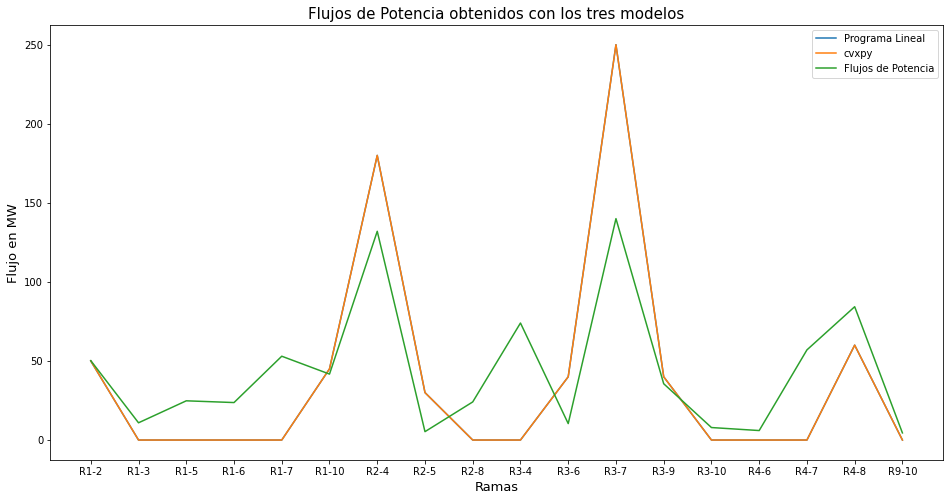

In [31]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(resultados.ramas,resultados.flujo_pl, label="Programa Lineal")
plt.plot(resultados.ramas,resultados.flujo_cvxpy, label="cvxpy")
plt.plot(resultados.ramas,resultados.flujo_fp, label="Flujos de Potencia")

plt.title("Flujos de Potencia obtenidos con los tres modelos",fontsize=15)
plt.xlabel("Ramas",fontsize=13)
plt.ylabel("Flujo en MW",fontsize=13)
plt.legend()
plt.show()

## Ejercicio con límites
Se hace el ejercicio utilizando ahoa límites en las ramas, con lo que se capturaría de mejor manera el comportaiento real de los elementos modelados, ya que las líneas de transmisión en realidad sí tienen límites en su transmisión.

In [33]:
bounds = [(0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150),
          (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150), (0, 150)]

In [34]:
print(linprog(c = costos, A_eq = incidencias, b_eq = b, bounds = bounds))

     con: array([ 7.10542736e-14, -4.32009983e-12, -2.75690581e-12,  5.74118530e-12,
       -6.18172180e-13, -8.17124146e-13,  5.05906428e-12, -5.82645043e-13,
       -8.31335001e-13, -9.66338121e-13])
     fun: 4.135455000013295
 message: 'Optimization terminated successfully.'
     nit: 9
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.00000000e+01, 2.40536355e-10, 2.31311534e-10, 4.00000000e+01,
       5.70451822e-10, 4.50000000e+01, 1.50000000e+02, 3.00000000e+01,
       7.00000000e+01, 6.00000000e+01, 1.15591791e-10, 1.50000000e+02,
       4.00000000e+01, 7.53960084e-10, 2.99553276e-11, 1.00000000e+02,
       1.30000000e+02, 4.12394580e-11])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [35]:
salida_pl = [1.00000000e+01, 2.40536355e-10, 2.31311534e-10, 4.00000000e+01,
       5.70451822e-10, 4.50000000e+01, 1.50000000e+02, 3.00000000e+01,
       7.00000000e+01, 6.00000000e+01, 1.15591791e-10, 1.50000000e+02,
       4.00000000e+01, 7.53960084e-10, 2.99553276e-11, 1.00000000e+02,
       1.30000000e+02, 4.12394580e-11]

In [36]:
resultados = pd.DataFrame(list(zip(ramas,salida_pl,salida_fp)), columns = ['ramas','flujo_pl','flujo_fp'])
resultados

,ramas,flujo_pl,flujo_fp
0,R1-2,1.000000e+01,50.2
1,R1-3,2.405364e-10,10.9
2,R1-5,2.313115e-10,24.8
3,R1-6,4.000000e+01,23.7
4,R1-7,5.704518e-10,53.0
5,R1-10,4.500000e+01,41.7
6,R2-4,1.500000e+02,132.0
7,R2-5,3.000000e+01,5.3
8,R2-8,7.000000e+01,24.1
9,R3-4,6.000000e+01,74.0


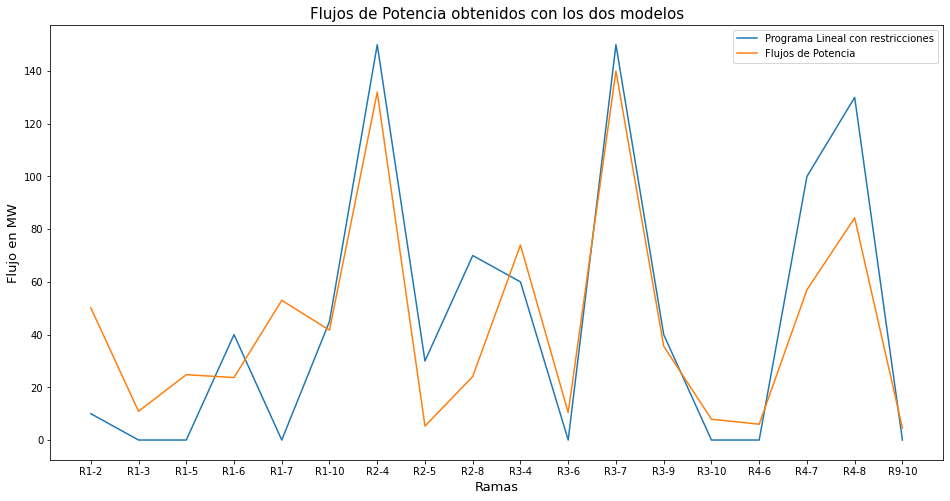

In [37]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(resultados.ramas,resultados.flujo_pl, label="Programa Lineal con restricciones")
plt.plot(resultados.ramas,resultados.flujo_fp, label="Flujos de Potencia")

plt.title("Flujos de Potencia obtenidos con los dos modelos",fontsize=15)
plt.xlabel("Ramas",fontsize=13)
plt.ylabel("Flujo en MW",fontsize=13)
plt.legend()
plt.show()